# Email Marketing Model

Globally, many organizations have implemented self-service functions for their customers. A self-service function can be thought of as an automated phone system, automated chatbot, online service, etc. This functionality serves two main functions:

    1. Seamless transaction for the customer to complete their desired task (payment, change of address) without waiting in a queue for a human representative.
    2. The cost associated with a self service functionality compared to a customer service operator is significantly lower. 

Payments are a recurring transaction, that for the most part do not require much interaction. This is primarily due to small fluctuations in payment amounts/due dates. Think of your recurring bills have they changed dramatically over the last year? Probably not.

Given the facts above, it would benefit the company and the customer to support and steer them into a self -service channel. In this project, our goal is to predict the likelihood that a policyholder will make a service payment call, so that we may send them a preemptive email message designed to encourage them to pay online.

## Data and Libraries

Modify the directory below to your local directory where the <a color=blue>DS_MiniProject_ANON.csv</a> and <a color=blue>function_call.py</a> file is saved. 

The file name <a color=blue>function_call.py</a> contains custom functions used throughout the notebook. To quickly view the functions uncomment "%load function_call" below.

In [1]:
# General Libs
import os
import sys
import pandas as pd
import numpy as np
from statistics import mean

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Dates
import dateutil.parser
import datetime as dt
import datetime

#preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost

#Metrics
from sklearn.metrics import f1_score,auc,roc_curve,average_precision_score
from sklearn.metrics import plot_confusion_matrix,make_scorer

#sampling
from sklearn.utils import resample
import six
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE

#cross validation
from sklearn.model_selection import RepeatedStratifiedKFold,RandomizedSearchCV,cross_validate,GridSearchCV
from imblearn.pipeline import Pipeline

# Call Save Functions
#set the directory
os.chdir("C:/Users/datascience/Desktop")
%run function_call

#ignore future warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Save Model
import pickle
#uncomment to view all save functions
#%load function_call

# Read in csv, line delimited file
df=pd.read_csv("DS_MiniProject_ANON.csv")
# set options for DataFrame
pd.set_option('display.max_columns', 30)

#view a few observations
df.head()

,DATE_FOR,RTD_ST_CD,CustomerSegment,Tenure,Age,MART_STATUS,GENDER,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,CHANNEL4_6M,CHANNEL5_6M,METHOD1_6M,RECENT_PAYMENT,PAYMENTS_6M,CHANNEL1_3M,CHANNEL2_3M,CHANNEL3_3M,CHANNEL4_3M,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,NOT_DI_3M,NOT_DI_6M,EVENT1_30_FLAG,EVENT2_90_SUM,LOGINS,POLICYPURCHASECHANNEL,Call_Flag
0,5/19/2014,ST_S0,1,16.175222,78.403833,MS_S0,F,0.0,0.0,1.0,0.0,5.0,0.0,0.0,6.0,0,0,1,0,2,0,3,0,0,0,0,0,0,0
1,5/17/2014,ST_S0,1,15.931554,70.989733,MS_S1,F,0.0,6.0,0.0,0.0,0.0,6.0,0.0,6.0,0,3,0,0,0,3,3,0,0,0,0,0,0,0
2,5/15/2014,ST_S0,1,15.937029,87.578371,MS_S2,M,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,0,0,6,0,0,0,6,0,0,0,0,0,0,0
3,5/16/2014,ST_S1,1,15.934292,68.438056,MS_S2,M,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,5/20/2014,ST_S0,1,15.501711,80.514716,MS_S0,F,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


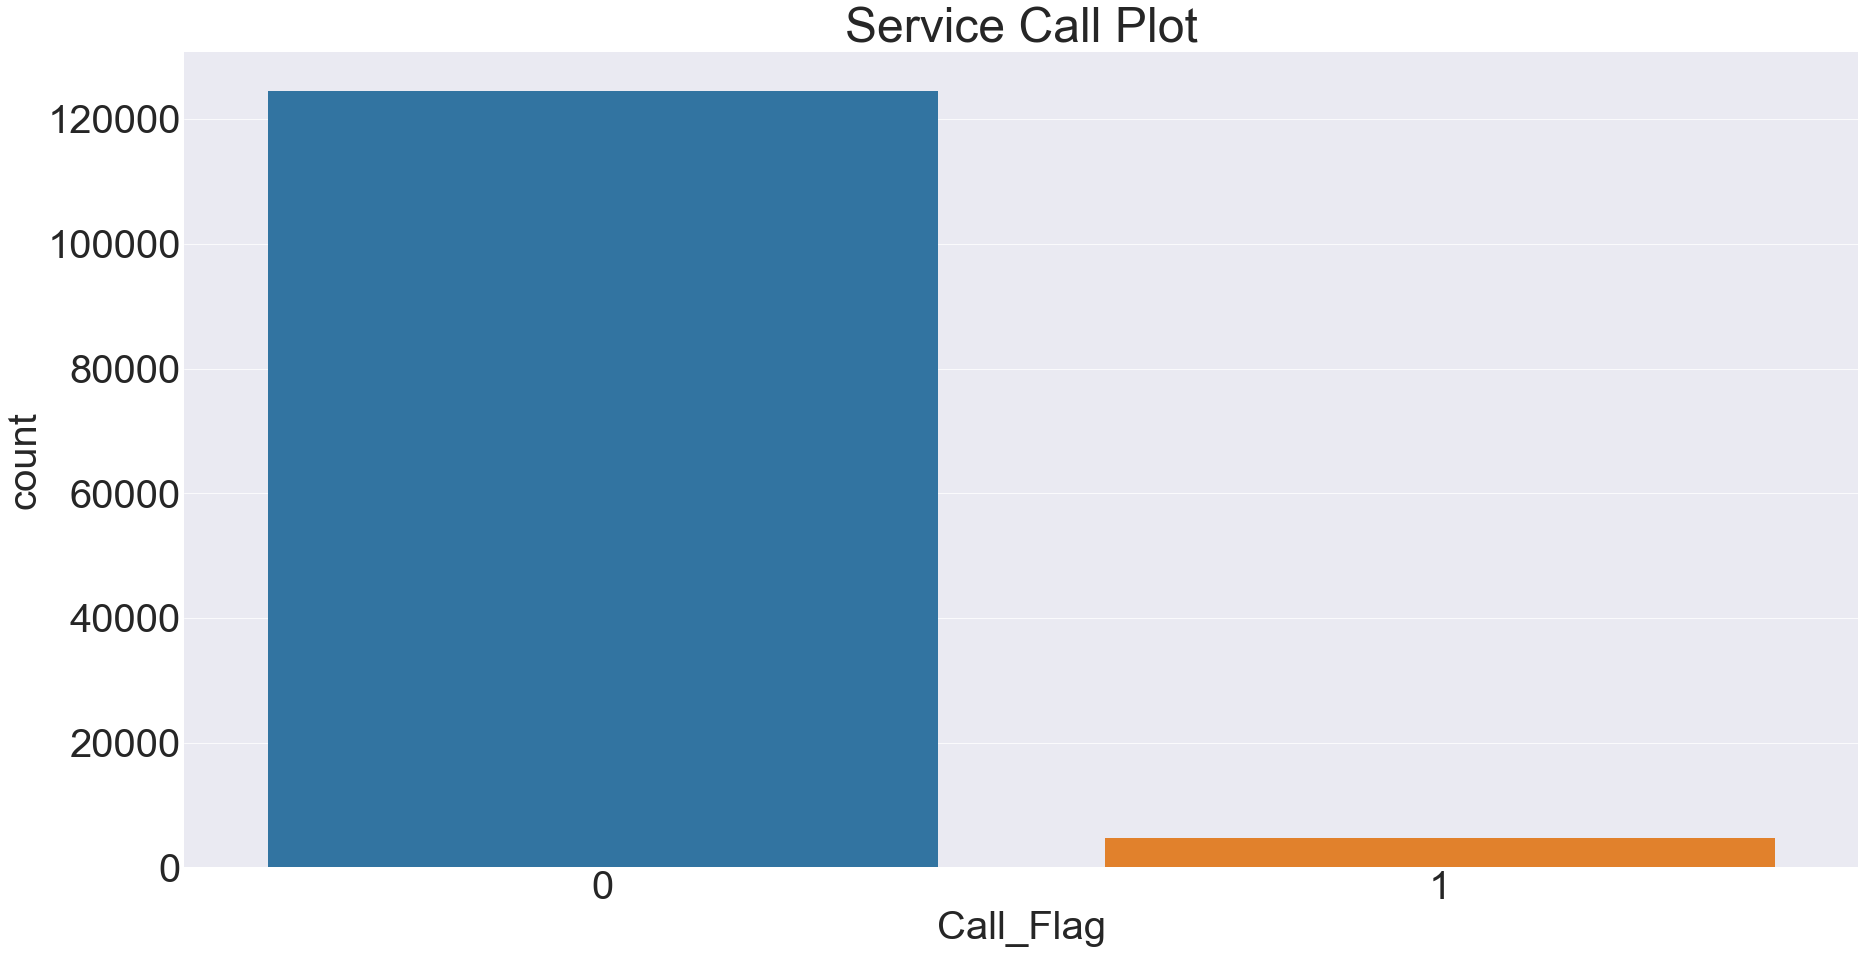

In [442]:
# Plot the payments with a service call
sns.set_color_codes("muted")
plt.title('Service Call Plot')
sns.countplot(x="Call_Flag", data=df)
plt.show()

## Assumptions

Below are a few assumptions about the data. The feature dictionary is vague in the description.

1. The features with the prefix 'Channel' represent a type of self-service feature such as automated phone, mobile app, web browser etc.
2. The features with the prefix 'Method1' represents the payment method used during the self-service channel (E.G credit card, debit card, electronic check, etc).
3. The target CALL_FLAG (set to 1) represents if a service payment call was made. We will assume that CALL_FLAG=0 indicates that a self-service payment was made.

## Data Exploration

Let's explore the shape of the dataset (namely, how many observations and how many features are included).

We will also want to capture some simple summary statistics about each of the features. For numeric values we will look at mean, min, max, etc and for categorical objects understand how many unique values and the most frequent object.

### Data Summary 

There are a few things to note from the summary table below. The table is a sanity check, there are 2 genders, the max age for the policyholder is ~99 years old, Tenure max ~63 years, and the total payments (3 mnt & 6 mnt) does not exceed the max of each channel. We might have some reservations about a policy holder who is 99 years old, but it is possible. They can be a lifetime policyholder with us who may live with a grandchild and have them under their policy, although they are no longer driving.


The one aspect that stands out is the imbalance dataset for the feature <b>Call_Flag</b>. Approximately ~3% of the dataset contains a service payment call. This is something we will have to deal with later in the project.

In [128]:
# Number of Records
print ('\n The data set contains',df.shape[0],'observations', 'and',df.shape[1],'features')
# Summarise all the Features
df.describe(include='all')


 The data set contains 129277 observations and 29 features


,DATE_FOR,RTD_ST_CD,CustomerSegment,Tenure,Age,MART_STATUS,GENDER,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,CHANNEL4_6M,CHANNEL5_6M,METHOD1_6M,RECENT_PAYMENT,PAYMENTS_6M,CHANNEL1_3M,CHANNEL2_3M,CHANNEL3_3M,CHANNEL4_3M,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,NOT_DI_3M,NOT_DI_6M,EVENT1_30_FLAG,EVENT2_90_SUM,LOGINS,POLICYPURCHASECHANNEL,Call_Flag
count,129277,129277,129277,129277.000000,129277.000000,129277,129277,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.0,129277.000000,129277.000000,129277.000000,129277.000000
unique,8,51,4,NaN,NaN,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,5/18/2014,ST_S7,1,NaN,NaN,MS_S2,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16884,24297,95349,NaN,NaN,57874,69399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,8.591581,48.813929,NaN,NaN,0.261810,0.948467,0.811652,0.401216,0.569823,1.834425,0.105680,4.848333,0.106825,0.477254,0.408247,0.197885,0.285333,0.914494,2.427145,0.056019,0.080502,0.0,0.193522,0.953774,0.131284,0.036549
std,NaN,NaN,NaN,7.297798,14.037131,NaN,NaN,1.092346,1.880123,1.824188,1.065413,1.628655,2.596754,0.307429,2.027548,0.527858,1.007308,0.960339,0.608286,0.850155,1.388627,1.211655,0.229960,0.272069,0.0,0.509437,2.149006,0.337712,0.187654
min,NaN,NaN,NaN,0.032854,16.689938,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,3.252567,37.845311,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,7.006160,49.111567,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,11.630390,58.830938,NaN,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000


<b>Service Agent Call</b>- How big of a problem is a service payment call? Below we look at what percent of the observation made a service payment call?

In [ ]:
<b>Service Agent Call</b>- How big of a problem is a service payment call? Below we look at what percent of the observation made a service payment call

In [2]:
# service calls
Call_Service=df['Call_Flag'].sum()
Perc_Call_srv= Call_Service/df.shape[0]
print(f'Approximately, {Perc_Call_srv:2.2%} of the observations called in to the service department for a payment.')

Approximately, 3.66% of the observations called in to the service department for a payment.


<b>Data Time Range</b> Although we have 130k observations, the data set only has transactions for a few days in May of 2014. Any inference that we uncover from this dataset might not represent the population of policyholder payments. There can be some seasonality in terms of service department calls, that would change the distribution month to month.

In [444]:
# Date Range of observations
print('The dataset has recorded payment transactions from',df['DATE_FOR'].min(),'-',df['DATE_FOR'].max())

The dataset has recorded payment transactions from 5/13/2014 - 5/20/2014


### Nulls & Missing Values

Below we are going to check for null values. What you will notice is that there are 809 observations will a null value for payments made in the last 6 months and for the feature recent payments.

A few things we can look at:

    - Given that payments made in the last 3 months are a subset of payments made in the last 6 months, we can place a lower bound on the number of payments. For example, if PAYMENTS_3M= 2 then PAYMENTS_6M is at least 2.
    - Was the policy started less than 6 months ago? If so there could be some issue with our data pull and/or aggregation. 
    - Use imputation methods such as setting missing values to the mean/median, or using KNN.
    
In the essence of time, we will opt to drop the missing values. The missing observation make up less than 1% of all observations, and luckily it only accounts for 0.82% of all service payments calls. Therefore, we do not make a significant impact on the imbalance that already exists.

In [78]:
# Concatenate checking the dataframe for nulls and missing values - sum by feature
null_chart=pd.DataFrame([df.isnull().sum(),df.eq('').sum()])
# rename and transpose dataframe
t_null=null_chart.rename({0:'Null',1:"Missing"},axis='index').T
# return nonzero values
t_null[(t_null.Missing>0)|(t_null.Null>0)]

,Null,Missing
CHANNEL1_6M,809,0
CHANNEL2_6M,809,0
CHANNEL3_6M,809,0
CHANNEL4_6M,809,0
CHANNEL5_6M,809,0
METHOD1_6M,809,0
RECENT_PAYMENT,809,0
PAYMENTS_6M,809,0


In [3]:
# Missing Observations with service payment call
miss_call=df.Call_Flag[df['RECENT_PAYMENT'].isnull()].sum()
print('Of the missing observations',miss_call,'have a service payment calls, this accounts for ',"{:,.2%}".format(miss_call/Call_Service))

#drop missing var
df=df.dropna()

Of the missing observations 39 have a service payment calls, this accounts for  0.82%


#### Tenure and Customer Age

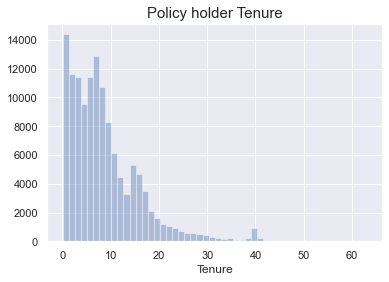

In [36]:
sns.set()
sns.distplot(df.Tenure,kde=False,axlabel='Tenure')
plt.title('Policy holder Tenure',fontsize=15)
plt.show()

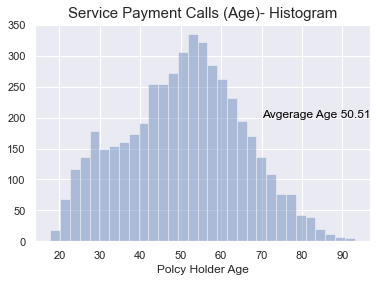

In [42]:
# PLot service Calls by age

#avg age with a service call
avg_age= df.Age[df.Call_Flag==1].mean()

#plot
plt.text(70,200, 'Avgerage Age {:,.2f}'.format(avg_age),color='black')
plt.title('Service Payment Calls (Age)- Histogram',fontsize=15)
sns.distplot(df.Age[df.Call_Flag==1],kde=False,axlabel='Polcy Holder Age')
plt.show()

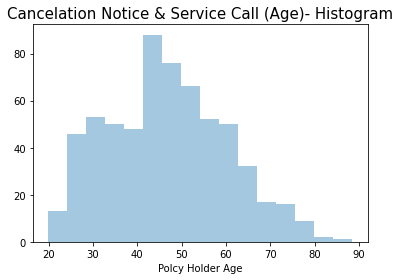

In [26]:
plt.title('Cancelation Notice & Service Call (Age)- Histogram',fontsize=15)
sns.distplot(df.Age[(df.EVENT2_90_SUM>0)&(df.Call_Flag==1)],kde=False,axlabel='Polcy Holder Age')
plt.show()

#### Payment Calls by Rated State

There is are 51 rated states in the dataset. From the graph below it looks as if we can condense the categories of this column. This will be helpful when creating dummy variables later on.

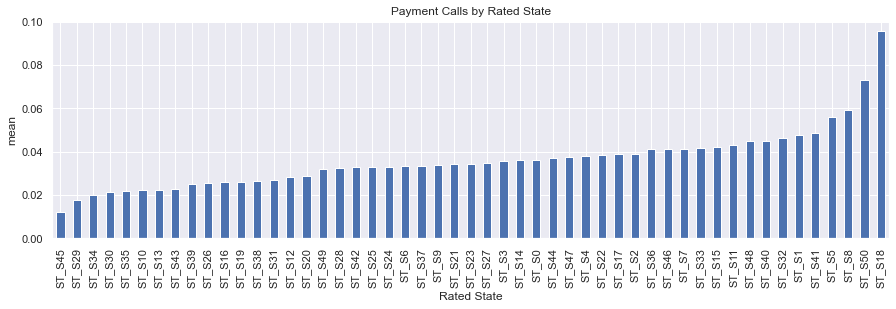

In [56]:
#Call Flag By Rated State
df.groupby("RTD_ST_CD")["Call_Flag"].mean().sort_values().plot(kind="bar", figsize=(15,4))
plt.title("Payment Calls by Rated State")
plt.xlabel("Rated State")
plt.ylabel("mean")
plt.show()

#### Age X Tenue

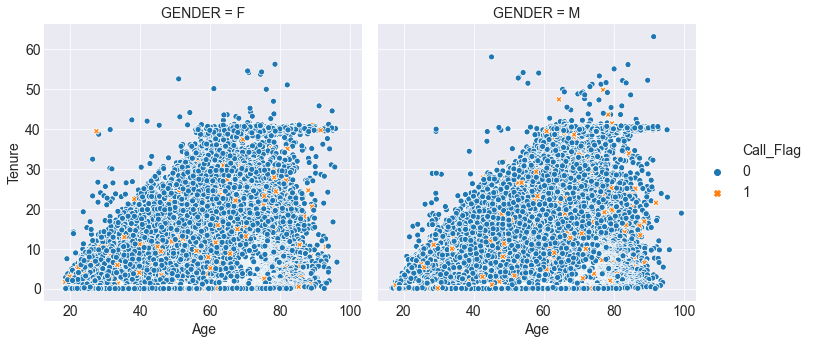

In [402]:
sns.relplot(
    data=df,
    x="Age",y="Tenure",col="GENDER",
    style='Call_Flag',hue='Call_Flag')

#### Correlation Heat Map

[Text(0.5, 0, 'Tenure'),
 Text(1.5, 0, 'Age'),
 Text(2.5, 0, 'CHANNEL1_6M'),
 Text(3.5, 0, 'CHANNEL2_6M'),
 Text(4.5, 0, 'CHANNEL3_6M'),
 Text(5.5, 0, 'CHANNEL4_6M'),
 Text(6.5, 0, 'CHANNEL5_6M'),
 Text(7.5, 0, 'METHOD1_6M'),
 Text(8.5, 0, 'RECENT_PAYMENT'),
 Text(9.5, 0, 'PAYMENTS_6M'),
 Text(10.5, 0, 'CHANNEL1_3M'),
 Text(11.5, 0, 'CHANNEL2_3M'),
 Text(12.5, 0, 'CHANNEL3_3M'),
 Text(13.5, 0, 'CHANNEL4_3M'),
 Text(14.5, 0, 'CHANNEL5_3M'),
 Text(15.5, 0, 'METHOD1_3M'),
 Text(16.5, 0, 'NOT_DI_3M'),
 Text(17.5, 0, 'NOT_DI_6M'),
 Text(18.5, 0, 'EVENT1_30_FLAG'),
 Text(19.5, 0, 'EVENT2_90_SUM'),
 Text(20.5, 0, 'LOGINS')]

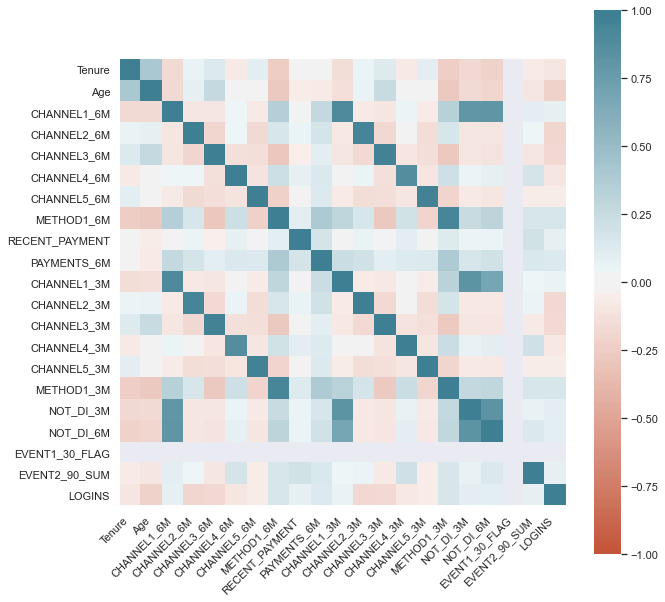

In [135]:
corr = df.iloc[:,[3,4,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25,26]].corr()

_,ax=plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

<b>Remove Overlap</b>

Payments made within 3 months is a subset of payments made within 6 months. We will remove the overlap and see if the correlation persist.

The correlation between the variables remains strong. Later in the project we will remove the variables with data from 6 months, we will assume that info from 3 months till the present will better represent the behavior of a customer to make a payment via SSC/ phone.

[Text(0.5, 0, 'CHANNEL1_3_to_6M'),
 Text(1.5, 0, 'CHANNEL2_3_to_6M'),
 Text(2.5, 0, 'CHANNEL3_3_to_6M'),
 Text(3.5, 0, 'CHANNEL4_3_to_6M'),
 Text(4.5, 0, 'CHANNEL1_3M'),
 Text(5.5, 0, 'CHANNEL2_3M'),
 Text(6.5, 0, 'CHANNEL3_3M'),
 Text(7.5, 0, 'CHANNEL4_3M')]

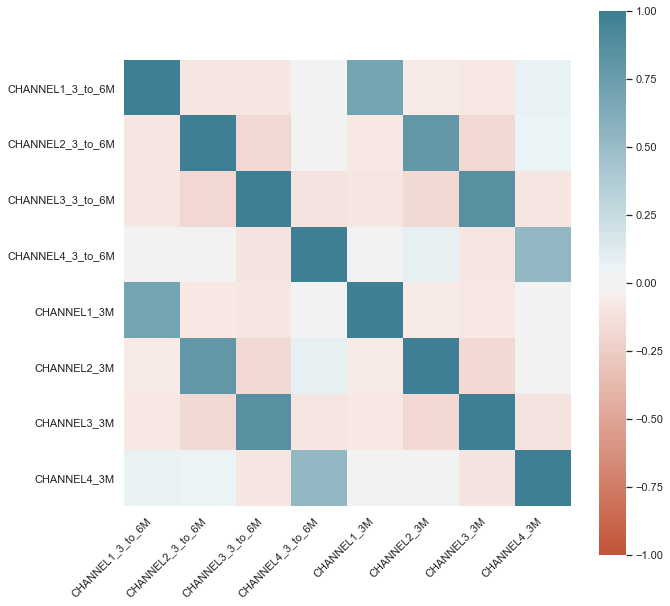

In [143]:
#remove the intersection of the variables
data=df.copy()

data['CHANNEL1_3_to_6M']=data['CHANNEL1_6M']-data['CHANNEL1_3M']
data['CHANNEL2_3_to_6M']=data['CHANNEL2_6M']-data['CHANNEL2_3M']
data['CHANNEL3_3_to_6M']=data['CHANNEL3_6M']-data['CHANNEL3_3M']
data['CHANNEL4_3_to_6M']=data['CHANNEL4_6M']-data['CHANNEL4_3M']



corr = data[['CHANNEL1_3_to_6M','CHANNEL2_3_to_6M','CHANNEL3_3_to_6M','CHANNEL4_3_to_6M','CHANNEL1_3M','CHANNEL2_3M','CHANNEL3_3M','CHANNEL4_3M']].corr()

_,ax=plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

#### Day of the week

There are more payment calls on monday, but there are also more calls on that day as well. 

<ipython-input-215-c050ca21d89b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['day'] = [datetime.datetime.strptime(x, '%M/%d/%Y').strftime('%A') for x in df.DATE_FOR]


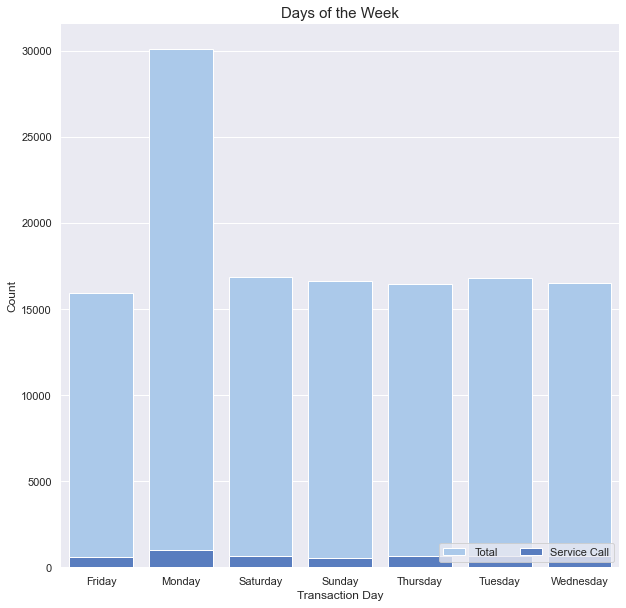

In [215]:
date_df=df[['DATE_FOR','Call_Flag']]
date_df['day'] = [datetime.datetime.strptime(x, '%M/%d/%Y').strftime('%A') for x in df.DATE_FOR]

#percent
days_count=date_df.groupby(['day'],as_index=False)[['Call_Flag']].count()
days_sum=date_df.groupby(['day'],as_index=False)[['Call_Flag']].sum()

days_sum['Total_cnt']=days_count.Call_Flag

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total payments
sns.set_color_codes("pastel")
sns.barplot(x="day", y="Total_cnt", data=days_sum,
            label="Total", color="b")

# Plot the payments with a service call
sns.set_color_codes("muted")
sns.barplot(x="day", y="Call_Flag", data=days_sum,
            label="Service Call", color="b")
            
# Add a legend and informative axis label
plt.title("Days of the Week",fontsize=15)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Count",
       xlabel="Transaction Day")
sns.despine(left=True, bottom=True)

In [440]:
df.Call_Flag.unique()

array([0, 1], dtype=int64)

The method above was unable to extract that the Customer_Segment has observations with the value 'None' instead of a numeric value. Without more information, we will assume that the customers did not fit into one of the three existing groups. Therefore, we will create a customer segment '4' to place these policyholders in.

In [219]:
# create a fourth customer segment
df.loc[df['CustomerSegment']=='NONE',['CustomerSegment']]=4

## Data Wrangling - Duplicate observations

There a duplicated observation in the data set, 29 to be exact. With the given information we are unable to determine if these are true duplicate, or just policyholders with the same information. 

In order to differentiate a true duplicate from similar customers would be with a customer id variable. Moving forward we will assume these observations are different policyholders with the same information.

In [220]:
# Check for duplicates counts
df[df.duplicated()==True].shape

(278, 29)

## Model

Build a predictive model to determine who is more likely to call in for a service payment call, to entice them to use a self-service channel instead.

### Baseline

#### Logistic Regression

We are going to use a Logistic Regression as our first model, to get a baseline for model performance. We going to perform some preprocessing then run the model and assess how well it performs.

We choose the Logistic Regression for the following reasons:
    - Non-Complex
    - Computational Time
    - Interpretability

It is a less complex model than many machine learning techniques used today (e.g Random Forest, XGBoost, Neural Networks, etc). There are use cases where we would want to get reasonable results with a simple model and save on complexity and computational time.

Additionally, when we are dealing with customer-facing decisions our models are subject to regulation and we may need to submit white papers to a government agency to explain our models and decisions. A Logistic Regression is a ubiquitous model and not necessarily deemed a "black-box model".

#### Preprocess
For Logistic Regression we are required to do a bit of preprocessing for the model to run. We will need to create dummy variables for categorical variables and convert date/time to python numeric dates.

Additionally, we will have a 2/3-1/3 stratified split for our training and test data sets. 

In [364]:
# Define the target and feature variables
y=df['Call_Flag'].copy()
X=df.copy().drop(['Call_Flag','DATE_FOR'],axis=1)
    
# Create Dummy Variables
cate_feat=['RTD_ST_CD','GENDER','MART_STATUS','CustomerSegment']
X=dummy_trans(X,cate_feat,drop=True)
X.drop(cate_feat,axis=1,inplace=True)

#Create a test/train split (1/3 - 2/3)
X_train,X_test, y_train,y_test =train_test_split(X,y,test_size=0.33)

#### Over Sample and Run Model

Below we run an out of the box model (no tuning). Additionally, we will use a technique called SMOTE - Synthetic Minority Oversampling Technique. Essentially, this method looks for a new observation in the feature space between the underrepresented class and creates new observations. In simpler terms consider two points on a graph and if you were to draw a line to connect them and then choose a point along that line to create a new observation. 

In [297]:
#Run Model
X_train,y_train=SMOTE().fit_resample(X_train,y_train)
LR = LogisticRegression(solver='newton-cg').fit(X_train,y_train)
                               
# Predictions (binary)
pred=LR.predict(X_test)
# Predictions (Probabilities)
pred_prob=LR.predict_proba(X_test)
# Keep the prob for service payment calls
LR_prob=pred_prob[:,1]

####  Model Performance

As noted above ~3% of the data has a service call payment event. Therefore, if we were to predict that every single observation was not a service call payment and choose accuracy as the model's success metric, our accuracy would be 97%. This would look amazing, but the model would fail to answer the business question.

We are concerned with identifying potential service call payments so that we may entice them to use our self-service methods.

Below we are going to explore the Confusion Matrix,ROC curve,precision-recall curve. 
- The confusion matrix show {TP,FP,TN,FN} at a given threshold 
- The ROC curve will demonstrate how well our model performs at different thresholds. When we change the thresholds we are saying more observation belongs to a particular class and therefore we will have a trade-off between True Positives and False Positives. 
- The Precision-Recall Curve lets us know how well we are doing correctly identifying the minority class.

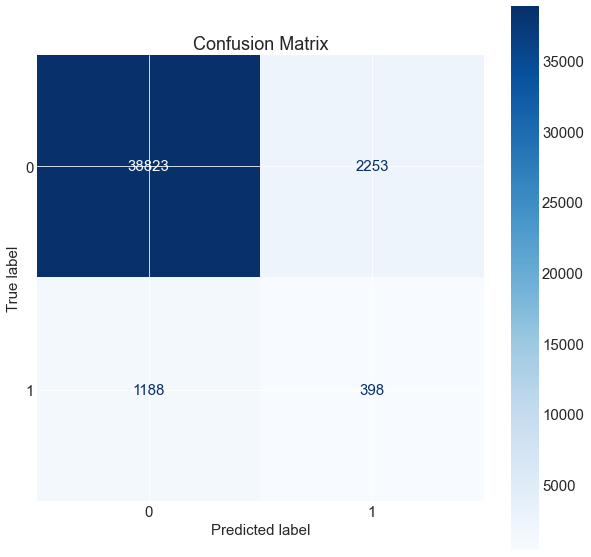

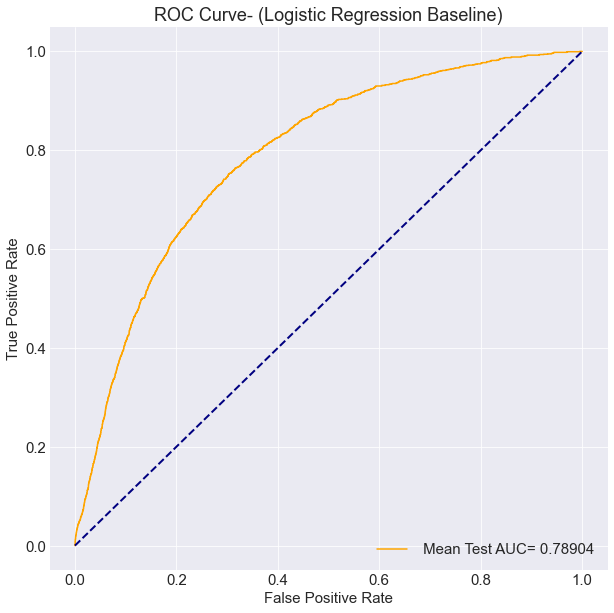

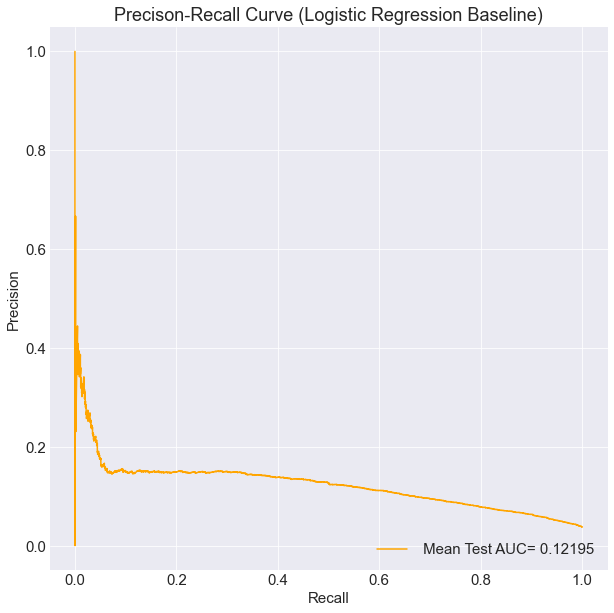

In [300]:
#plot presets
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size']=10

# Plot Confustion Matrix
plt.style.use('seaborn-darkgrid')
disp = plot_confusion_matrix(LR, X_test, y_test,
                             cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
plt.show()
#roc plot
roc_graph(y_test,LR_prob,title='ROC Curve- (Logistic Regression Baseline)')
#Precision Reacll Graph
PR_graph(y_test,LR_prob,title='Precison-Recall Curve (Logistic Regression Baseline)')

The ROC curve is an optimistic representation of the models performance. The ROC curve is telling us how well our model is at differentiating the classes, but when one of the classes (Call_Flag=0) is over represented then getting it classified correctly is not to difficult of a task.

The Precision-Recall Curve gives us a better picture of how well the model is doing at predicting the minority class, since it does not depend on the TN.

## HyperParameter Tuning

Can we do any better than the results above?

#### Feature Engineer and Sampling

Below is a list with explanations of each new feature.

- <b>Cancel_autom</b>: Canceled automated payments
- <b>SSP_6M</b>: Percent of self-service payment in the last 6 months.
- <b>SSP_15d</b>: Was the payment made in the last 15 days potentially made through SSC?
- <b> day </b>: Day of the week for the transaction.
- <b> state_grp </b>: Rated State grouped by (ascending) Call_Flag=1.

In [3]:
# Define the target and feature variables
y=df['Call_Flag'].copy()
X=df.copy().drop(['Call_Flag'],axis=1)
# Define the target and feature variables
y=df['Call_Flag'].copy()
X=df.drop(['Call_Flag'],axis=1).copy()

# Percent of self service payment in the last 3 months
X['SSP_6M']=X.iloc[:,15:19].sum(axis=1)/X['PAYMENTS_6M']
X['SSP_6M']=X['SSP_6M'].fillna(0)

# Cancelled automated payments
X.loc[(X.NOT_DI_6M ==1) & (X.NOT_DI_3M ==0), 'Cancel_autom'] = 1
X['Cancel_autom']=X['Cancel_autom'].fillna(0)

# Potential SSC payments this month
X.loc[(X.SSP_6M >0) & (X.RECENT_PAYMENT ==1), 'SSP_15d'] = 1
X['SSP_15d']=X['SSP_15d'].fillna(0)

#days of the week
X['day'] = [datetime.datetime.strptime(x, '%M/%d/%Y').strftime('%A') for x in X.DATE_FOR]

#state group
state_grp=pd.cut(df.groupby(
            "RTD_ST_CD")["Call_Flag"].mean().sort_values(), 5, labels=[
            "1","2","3","4","5"])
state_grp=pd.DataFrame(state_grp).rename(columns={'Call_Flag':'state_grp'})
X=pd.merge(X,state_grp,on="RTD_ST_CD",how="left")

In [4]:
#Preprocess
#drop
X.drop(['RTD_ST_CD','CHANNEL1_3M','CHANNEL2_3M','CHANNEL3_3M','CHANNEL4_3M','CHANNEL5_3M','METHOD1_3M','PAYMENTS_3M','NOT_DI_3M','EVENT1_30_FLAG','DATE_FOR'],axis=1,inplace=True)

In [5]:
#Create a test/train split (1/3 - 2/3)
X_train,X_test, y_train,y_test =train_test_split(X,y,test_size=0.25,stratify=y)
# initiate stratified k fold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
# score list
scorers = ['roc_auc','average_precision']

#### Logistic Regression- Tune Hyper Param

In [ ]:
#### Logistic Regression - Tune Parameters (Regularization Term)

#Pipeline for each model
LR_pipe= Pipeline ([('dummy',DummyEncoder()),('over', SMOTE()),('LR',LogisticRegression())])

#grid to for hyperparameters
LR_param_grid = [
    {'LR__penalty' : ['l2'],
    'LR__C' : np.logspace(-4, 4, 15),
    'LR__solver' : ['newton-cg']}
]

LR_clf_tmp = RandomizedSearchCV(LR_pipe, param_distributions = LR_param_grid, cv = cv,scoring=scorers,refit='average_precision',verbose=True,n_jobs=6,return_train_score=True)
LR_model=LR_clf_tmp.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


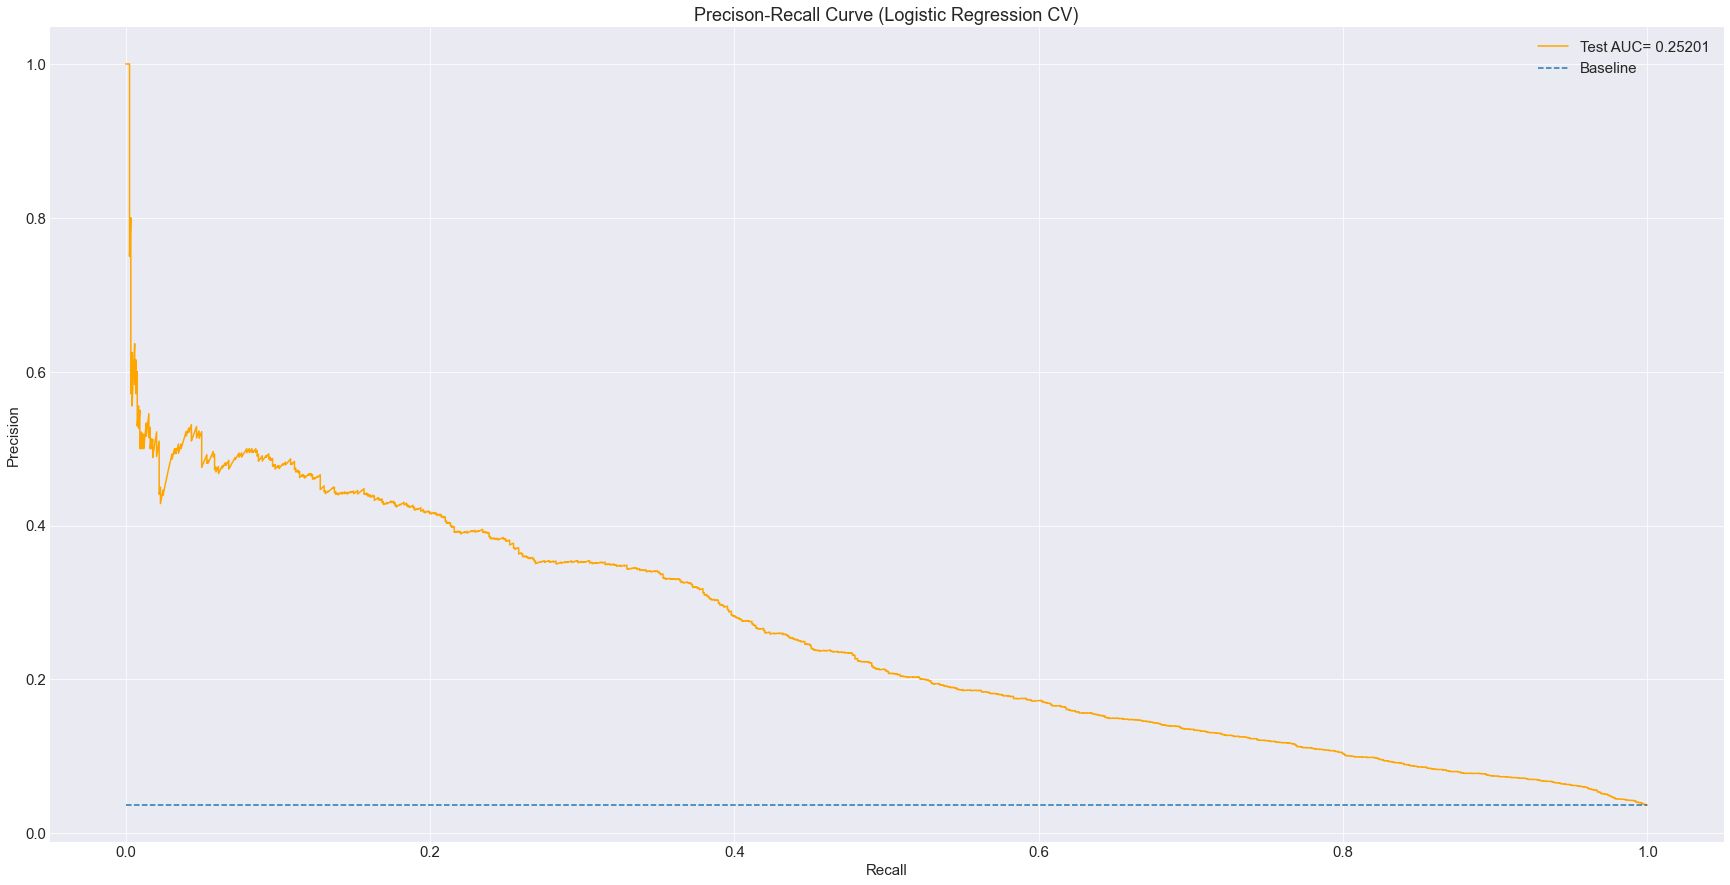

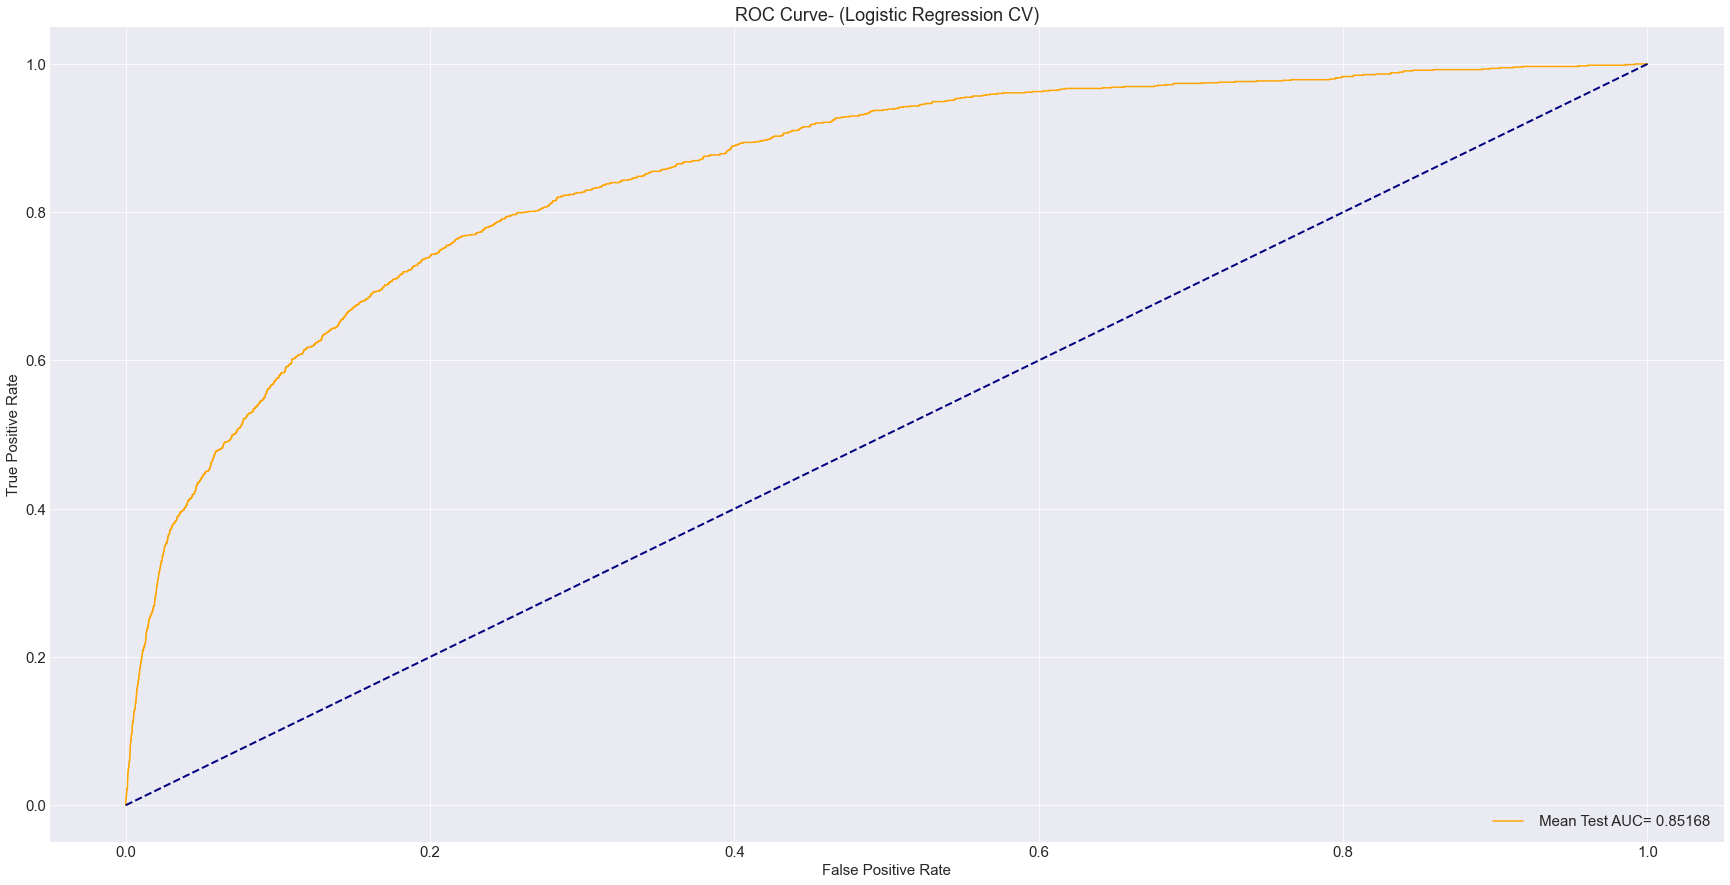

In [456]:
#best model predictor
LR_y_pred=LR_clf.best_estimator_.named_steps['LR'].predict_proba(DummyEncoder().transform(X_test))
#precision recall graph
PR_graph(y_test,LR_y_pred[:,1],title='Precison-Recall Curve (Logistic Regression CV)')
#ROC Curve
roc_graph(y_test,LR_y_pred[:,1],title='ROC Curve- (Logistic Regression CV)')

## Random Forest

In [380]:
#Pipeline for each model

#RF_pipe = Pipeline([('Encode',MultiColumnLabelEncoder(columns=['GENDER','MART_STATUS','state_grp','CustomerSegment','day'])),('over', SMOTE()),('RF' , RandomForestClassifier())])
RF_pipe = Pipeline([('Encode',MultiColumnLabelEncoder(columns=['GENDER','MART_STATUS','state_grp','CustomerSegment','day'])),('RF' , RandomForestClassifier(class_weight='balanced'))])

#grid to for hyperparameters
RF_param_grid = [
    {'RF__n_estimators' : list(range(100,501,100)),
    'RF__max_features' : list(range(10,X.shape[1],2))}
]


RF_clf = RandomizedSearchCV(RF_pipe, param_distributions = RF_param_grid, cv = cv,scoring=scorers,refit='average_precision',verbose=True,n_jobs=6)
RF_model = RF_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed: 25.8min finished


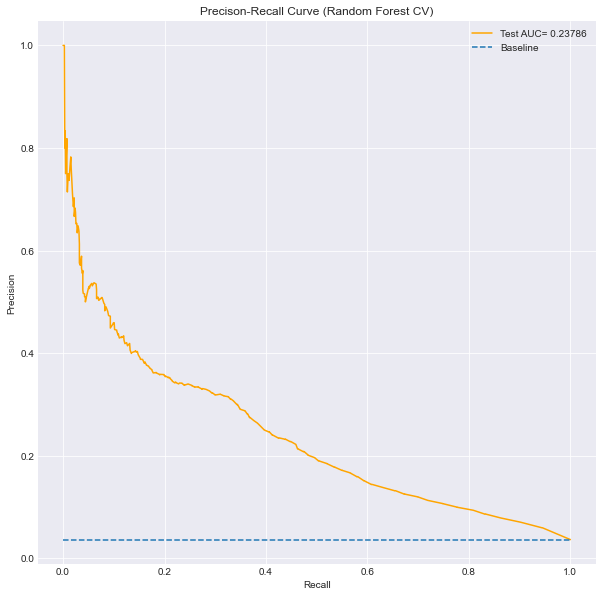

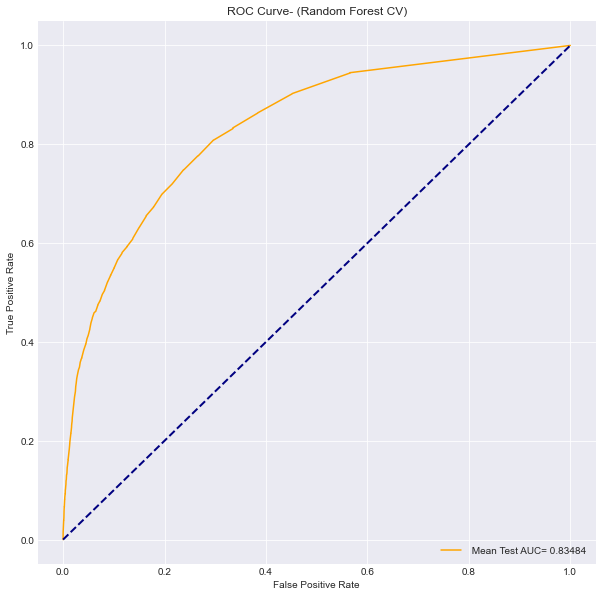

In [389]:
# Test Prediction
rf_y_pred=RF_model.best_estimator_.named_steps['RF'].predict_proba( MultiColumnLabelEncoder(columns=['GENDER','MART_STATUS','state_grp','CustomerSegment','day']).fit_transform(X_test))
#precision recall graph
PR_graph(y_test,rf_y_pred[:,1],title='Precison-Recall Curve (Random Forest CV)')
#ROC Curve
roc_graph(y_test,rf_y_pred[:,1],title='ROC Curve- (Random Forest CV)')

## XGboost

In [6]:
#xgboost model
xg_param_grid=[{
        #'smote__k_neighbors':[0,1,3,5,8,10],
        'xg__scale_pos_weight': np.arange(1,30,1),
        'xg__subsample': [0.6, 0.8, 1.0],
        'xg__colsample_bytree': [0.6, 0.8, 1.0],
        'xg__max_depth': [3, 4, 5,10,15]
        }]

#Pipeline for each model
xg_pipe = Pipeline([("encode", MultiColumnLabelEncoder(columns=['GENDER','MART_STATUS','state_grp','CustomerSegment','day'])),('xg' , XGBClassifier())])


xg_clf = RandomizedSearchCV(xg_pipe, param_distributions = xg_param_grid, cv = cv,scoring=scorers,refit='average_precision',verbose=True,n_jobs=4)
xg_model = xg_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  5.5min finished


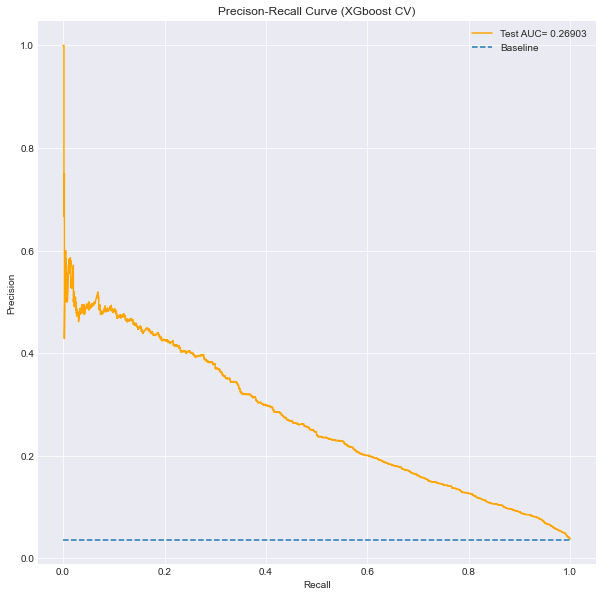

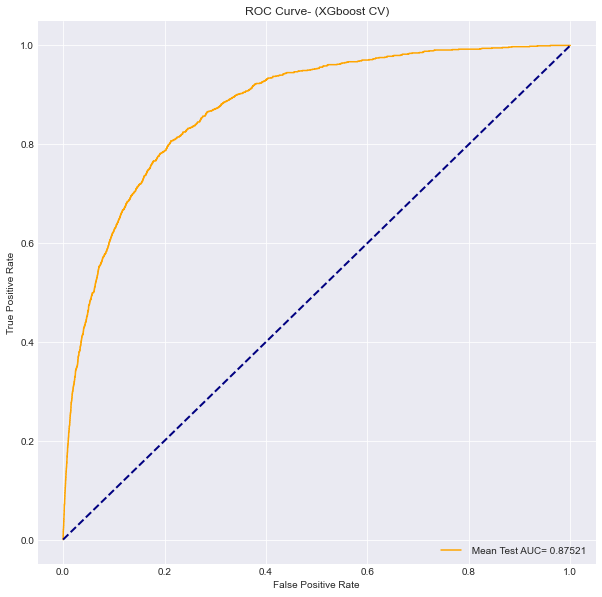

In [388]:
#plot presets
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size']=10
# Test Prediction
xg_y_pred=xg_model.best_estimator_.named_steps['xg'].predict_proba( MultiColumnLabelEncoder(columns=['GENDER','MART_STATUS','state_grp','CustomerSegment','day']).fit_transform(X_test))
#precision recall graph
PR_graph(y_test,xg_y_pred[:,1],title='Precison-Recall Curve (XGboost CV)')
#ROC Curve
roc_graph(y_test,xg_y_pred[:,1],title='ROC Curve- (XGboost CV)')

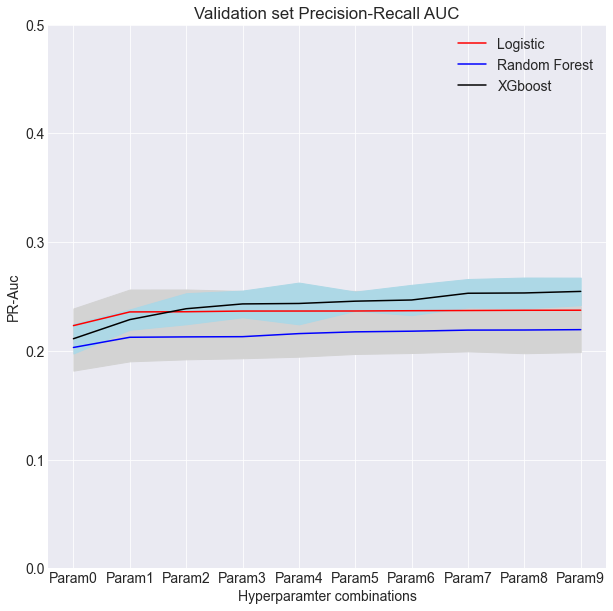

,0,xg__subsample,xg__scale_pos_weight,xg__max_depth,xg__colsample_bytree
0,Param0,1.0,2,15,0.6
1,Param1,0.6,11,5,0.6
2,Param2,1.0,28,5,1.0
3,Param3,1.0,8,5,0.6
4,Param4,1.0,17,5,0.6
5,Param5,1.0,26,4,0.8
6,Param6,0.8,20,3,1.0
7,Param7,0.6,8,3,0.6
8,Param8,1.0,15,3,1.0
9,Param9,0.8,4,3,0.8


In [401]:
#validation precision metric
#plot presets
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size']=14

#sort scores XGboost
xg_score=xg_model.cv_results_['mean_test_average_precision']
xg_score_std=xg_model.cv_results_['std_test_average_precision']

xg_params=xg_model.cv_results_['params']

xg_tuples=zip(*sorted(zip(xg_score,xg_params,xg_score_std)))
xg_score_sorted,xg_params_sorted,xg_score_std_sort=[list(tuple) for tuple in xg_tuples]

#sort scores Logistic 
LG_score=LR_model.cv_results_['mean_test_average_precision']
LG_score_std=LR_model.cv_results_['std_test_average_precision']

LG_params=LR_model.cv_results_['params']

LG_tuples=zip(*sorted(zip(LG_score,LG_params,LG_score_std)))
LG_score_sorted,LG_params_sorted,LG_score_std_sort=[list(tuple) for tuple in LG_tuples]

#sort scores Random Forest 
RF_score=RF_model.cv_results_['mean_test_average_precision']
RF_score_std=RF_model.cv_results_['std_test_average_precision']

RF_params=RF_model.cv_results_['params']

RF_tuples=zip(*sorted(zip(RF_score,RF_params,RF_score_std)))
RF_score_sorted,RF_params_sorted,RF_score_std_sort=[list(tuple) for tuple in RF_tuples]

#x val
rng=list(map(str,range(0,len(score),1)))
x_param = [str('Param') + sub for sub in rng]

#Plot Validation Scores
plt.figure(figsize=(10,10))
#logistic
plt.plot(pre_res,LG_score_sorted,color='red',label='Logistic')
plt.fill_between(pre_res,np.array(LG_score_sorted)-np.array(LG_score_std_sort),np.array(LG_score_sorted)+np.array(LG_score_std_sort),color='lightgray')
#Random Forest
plt.plot(pre_res,RF_score_sorted,color='blue',label='Random Forest')
plt.fill_between(pre_res,np.array(RF_score_sorted)-np.array(RF_score_std_sort),np.array(RF_score_sorted)+np.array(RF_score_std_sort),color='lightgray')
#xgboost
plt.plot(pre_res,xg_score_sorted,color='black',label='XGboost')
plt.fill_between(pre_res,np.array(xg_score_sorted)-np.array(xg_score_std_sort),np.array(xg_score_sorted)+np.array(xg_score_std_sort),color='lightblue')
#options
plt.title('Validation set Precision-Recall AUC')
plt.xlabel('Hyperparamter combinations')
plt.ylabel('PR-Auc')
plt.ylim(0,0.5)
plt.legend()
plt.show()

#priny X labels dictionary

X_dict=pd.concat([pd.DataFrame(pre_res),pd.DataFrame(xg_params_sorted)],axis=1)
X_dict

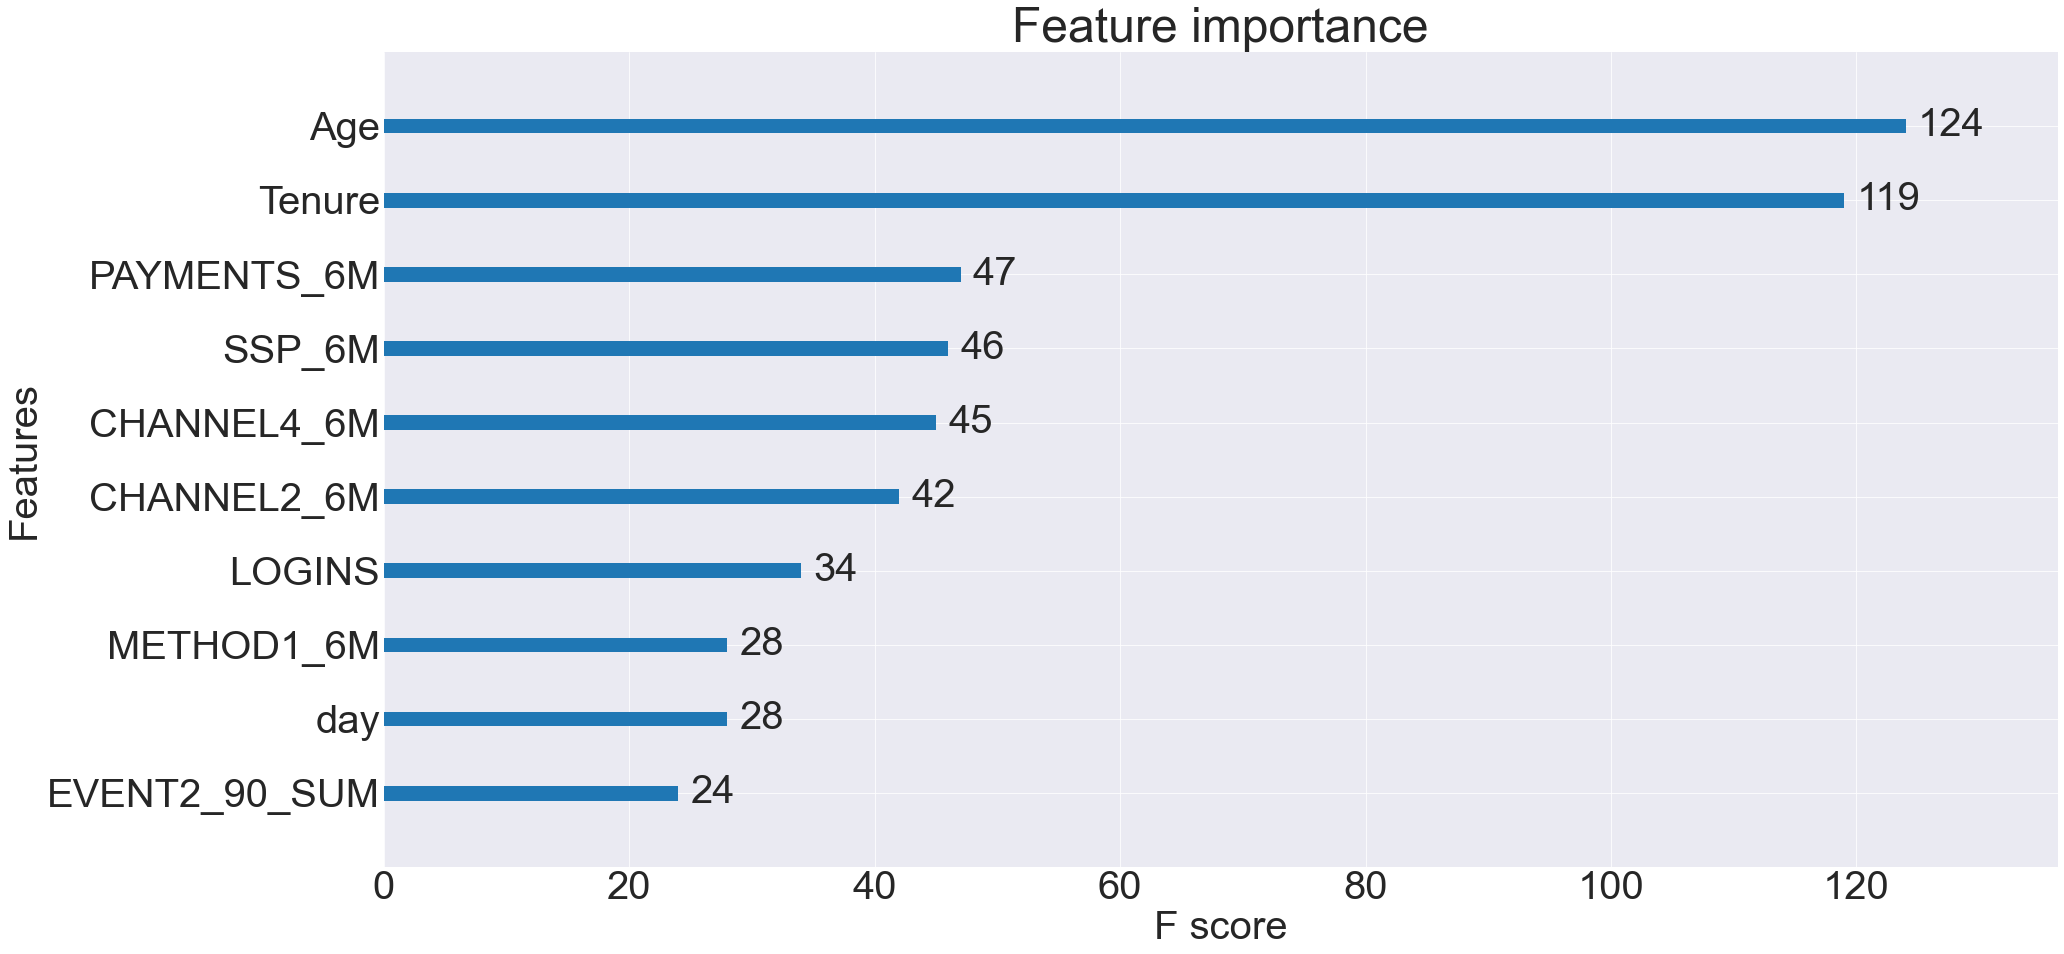

In [436]:
#plot Feature Importance 

plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams['font.size']=40
xgboost.plot_importance(xg_model.best_estimator_.named_steps['xg'],max_num_features=10,)
plt.show()

### SHAP Values

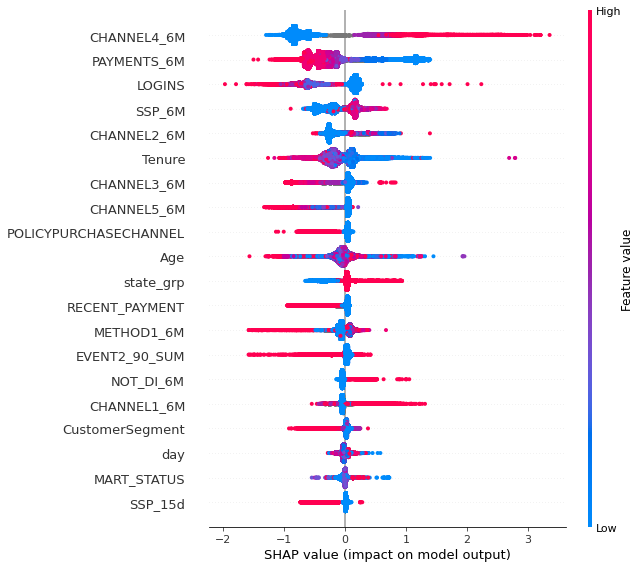

In [18]:
X=X_train.copy()
X=MultiColumnLabelEncoder(columns=['GENDER','MART_STATUS','state_grp','CustomerSegment','day']).transform(X)
expl=shap.TreeExplainer(xg_model.best_estimator_[1])
shap_values = expl.shap_values(X)
shap.initjs()
shap.summary_plot(shap_values, X)

## Precision Recall Chart

In [120]:
from sklearn.metrics import precision_score,recall_score
predictions=xg_y_pred[:,1]
a=[]
b=[]
threshold=list(np.arange(0,1.0,.1))
for i in range(10):
    new_pred=np.where(predictions<threshold[i],0,1)
    a.append(precision_score(y_test,new_pred))
    b.append(recall_score(y_test,new_pred))

prec_recall_chart=pd.DataFrame([threshold,a,b]).transpose()

In [121]:
prec_recall_chart.rename(columns={0:'Thresholds',1:'Precision',2:'Recall'})

,Thresholds,Precision,Recall
0,0.0,0.036621,1.000000
1,0.1,0.062497,0.963056
2,0.2,0.075982,0.927792
3,0.3,0.090095,0.887490
4,0.4,0.110102,0.794291
5,0.5,0.139700,0.727120
6,0.6,0.175814,0.634761
7,0.7,0.221750,0.525609
8,0.8,0.299376,0.362720
9,0.9,0.441758,0.168766
